# Causal AI with DataRobot: Inverse Propensity of Treatment Weighting

## Summary

Predictive AI models are a powerful tool for uncovering subtle predictive relationships between observed variables. But sometimes, you need to draw conclusions about the causal relationship between two variables, not just the observed correlation. To achieve this "Causal AI", you can use the DataRobot platform and a quasi-experimental technique called "Inverse Propensity of Treatment Weighting". This notebook will apply this technique to data on diabetes hospital patient readmission. 

This notebook outlines how to:

1. Understand Inverse Propensity of Treatment Weighting
1. Prepare data for a Propensity of Treatment model
1. Fit a Propensity of Treatment model with DataRobot
1. Calculate Inverse Propensity of Treatment Weights
1. Evaluate the causal relationship using Inverse Propensity of Treatment Weighting

### Understanding Inverse Propensity of Treatment Weighting
In this notebook, you will be working with data recording hospital readmission outcomes for diabetes patients. You will evaluate the causal relationship between the diabetes patients' medication status and their subsequent chance of being readmitted to the hospital. 

To evaluate this causal relationship experimentally, you would have to randomly assign patients to the treament group (those receiving medication) vs. not, and then follow those patients to see whether they get readmitted to the hospital or not. But in the scenario for this notebook, you don't have experimental data! You only have observational data. In other words, some patients walk in taking medication, others don't. You have not controlled the assignment of the "treatment" condition (medication) to the subjects of the study. So while you could use predictive modeling to understand if the medication status of patients walking in is predictive of later readmission, you can't directly use predictive models to make conclusions about whether the medication has a *causal effect* on readmission. 

In this scenario, you can use a "quasi-experimental" technique; this is a set of techniques for approximating experimental setups without actually having a true experiment. Specifically, you can use a technique called "Inverse Propensity of Treatment Weighting".

Inverse Propensity of Treatment Weighting consists of the following steps:
1. Fit a predictive model to estimate the probability for each study participant being assinged to the treatment group (their "propensity of treatment").
1. Calculate a special weight for each participant based on their propensity of treatment (the "inverse propensity of treatment weight"), which will adjust the treatment and control groups to become more similar to each other in terms of the observed confounding variables.
1. Evaluate the causal relationship between the treatment and the outcome using the adjusted/weighted populations (pseudopopulations).

While this technique is not as valid as the gold standard of a randomized controlled trial, it can bring you a lot closer to obtaining comparable treatment and control groups from which to judge a causal relationship. 
 
For a more detailed description of this technique, see:

> Chesnaye, N. C., Stel, V. S., Tripepi, G., Dekker, F. W., Fu, E. L., Zoccali, C., & Jager, K. J. (2021). An introduction to inverse probability of treatment weighting in observational research. Clinical kidney journal, 15(1), 14–20. https://doi.org/10.1093/ckj/sfab158

### Setup
To start, set up your libraries, DataRobot connection, and data ingest.

#### Import libraries

In [66]:
from io import BytesIO
import os

import datarobot as dr
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import pandas as pd
import seaborn as sns

#### Connect to DataRobot

You can read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [18]:
dr.Client()

#### Data Ingest

This data is a modified subset of the data from the following research article:
> Strack, B., DeShazo, J. P., Gennings, C., Olmo, J. L., Ventura, S., Cios, K. J., & Clore, J. N. (2014). Impact of HbA1c measurement on hospital readmission rates: analysis of 70,000 clinical database patient records. BioMed research international, 2014, 781670. https://doi.org/10.1155/2014/781670

The number of rows and columns have been reduced for the purposes of this example.

In [19]:
working_df = pd.read_csv("storage/diabetes_subset.csv")
working_df

,readmitted,race,gender,age,weight,admission_type_id,admission_source_id,number_inpatient,medical_specialty,num_lab_procedures,number_diagnoses,num_medications,time_in_hospital,diabetesMed
0,False,Caucasian,Female,[50-60),?,Elective,Physician Referral,0,Surgery-Neuro,35,9,21,1,No
1,False,Caucasian,Female,[20-30),[50-75),Urgent,Physician Referral,0,?,8,6,5,2,No
2,True,Caucasian,Male,[80-90),?,Not Available,NaN,1,Family/GeneralPractice,12,9,21,7,Yes
3,False,AfricanAmerican,Female,[50-60),?,Emergency,Transfer from another health care facility,0,?,33,3,5,4,Yes
4,False,AfricanAmerican,Female,[50-60),?,Emergency,Emergency Room,0,Psychiatry,31,7,13,5,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,Caucasian,Female,[60-70),?,Elective,Physician Referral,0,?,30,7,29,3,Yes
9996,False,AfricanAmerican,Male,[60-70),?,Urgent,Emergency Room,0,Emergency/Trauma,1,9,15,8,Yes
9997,True,AfricanAmerican,Female,[70-80),?,Emergency,Emergency Room,1,InternalMedicine,46,6,14,13,No
9998,False,Caucasian,Male,[80-90),?,Urgent,Emergency Room,3,InternalMedicine,62,9,7,2,No


In this dataset, you have the outcome of hospital readmission (`readmitted`), the treatment variable of diabetes medication (`diabetesMed`), and a number of covariates.

#### Visualization

To start off, take a look at the observed correlation of the treatment variable and the outcome.

It appears that patients that are on diabetes medication have slightly higher rates of readmission. But is this a causal effect, or a spurious correlation? To find that out you need to obtain comparable treatment and control groups.

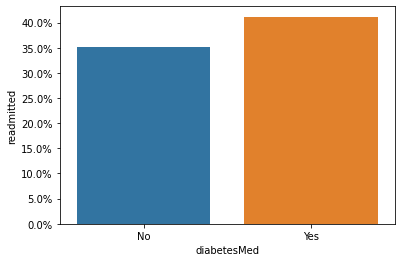

In [34]:
plot_df = working_df.groupby("diabetesMed").readmitted.mean().to_frame().reset_index()
p = sns.barplot(data=plot_df, x="diabetesMed", y="readmitted")
p.axes.yaxis.set_major_formatter(PercentFormatter(1))

## Prepare data for a Propensity of Treatment model

The data for the Propensity of Treatment model is simply all of the variables in your dataset **except** the outcome (here, the `readmitted` variable). Remember, in this first stage, the target for your model will be the treatment variable (`diabetesMed`), not the readmission outcome.

In [43]:
propensity_df = working_df.drop(columns=["readmitted"])
propensity_df

,race,gender,age,weight,admission_type_id,admission_source_id,number_inpatient,medical_specialty,num_lab_procedures,number_diagnoses,num_medications,time_in_hospital,diabetesMed
0,Caucasian,Female,[50-60),?,Elective,Physician Referral,0,Surgery-Neuro,35,9,21,1,No
1,Caucasian,Female,[20-30),[50-75),Urgent,Physician Referral,0,?,8,6,5,2,No
2,Caucasian,Male,[80-90),?,Not Available,NaN,1,Family/GeneralPractice,12,9,21,7,Yes
3,AfricanAmerican,Female,[50-60),?,Emergency,Transfer from another health care facility,0,?,33,3,5,4,Yes
4,AfricanAmerican,Female,[50-60),?,Emergency,Emergency Room,0,Psychiatry,31,7,13,5,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Caucasian,Female,[60-70),?,Elective,Physician Referral,0,?,30,7,29,3,Yes
9996,AfricanAmerican,Male,[60-70),?,Urgent,Emergency Room,0,Emergency/Trauma,1,9,15,8,Yes
9997,AfricanAmerican,Female,[70-80),?,Emergency,Emergency Room,1,InternalMedicine,46,6,14,13,No
9998,Caucasian,Male,[80-90),?,Urgent,Emergency Room,3,InternalMedicine,62,9,7,2,No


### Examine differences between treatment and control groups

Now take a look at your unadjusted treatment and control groups. How different are they on the covariates?

<AxesSubplot:xlabel='number_diagnoses', ylabel='Density'>

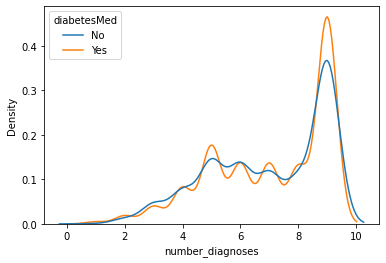

In [44]:
sns.kdeplot(data=propensity_df, x="number_diagnoses", hue="diabetesMed", common_norm=False)

<AxesSubplot:xlabel='num_lab_procedures', ylabel='Density'>

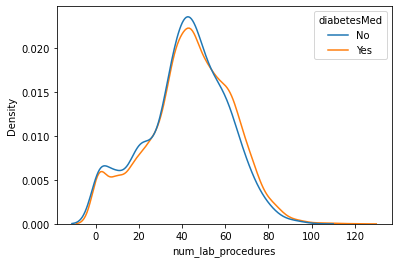

In [45]:
sns.kdeplot(data=propensity_df, x="num_lab_procedures", hue="diabetesMed", common_norm=False)

<AxesSubplot:xlabel='num_medications', ylabel='Density'>

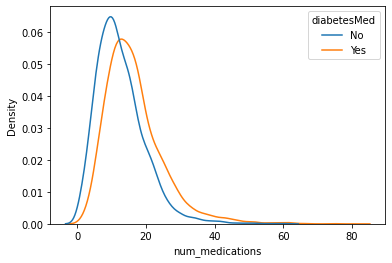

In [46]:
sns.kdeplot(data=propensity_df, x="num_medications", hue="diabetesMed", common_norm=False)

<AxesSubplot:xlabel='time_in_hospital', ylabel='Density'>

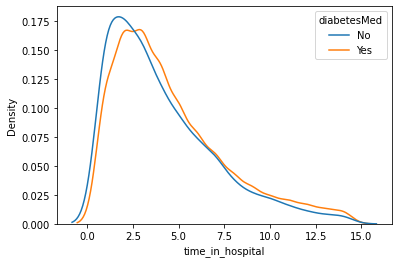

In [47]:
sns.kdeplot(data=propensity_df, x="time_in_hospital", hue="diabetesMed", common_norm=False)

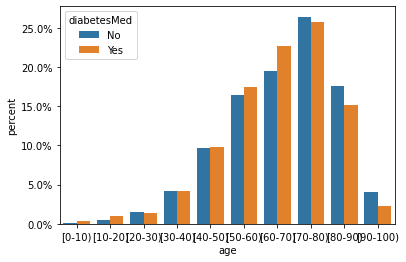

In [48]:
plot_df = (
    propensity_df.assign(sampling_weight=1)  # unweighted
    .groupby(["diabetesMed", "age"])
    .sampling_weight.sum()
    .pipe(lambda df: df / df.groupby("diabetesMed").transform("sum"))
    .to_frame("percent")
    .reset_index()
)
p = sns.barplot(data=plot_df, x="age", y="percent", hue="diabetesMed")
p.axes.yaxis.set_major_formatter(PercentFormatter(1))

(For a complete analysis, you would continue looking at the remaining covariates.)

From the above plots, you can see that the treatment and control groups (`diabetesMed==Yes` vs. `diabetesMed==No`) have somewhat different distributions for the covariates `num_medications`, `time_in_hospital`, and `age`. These differences between the treatment and control groups could be confounding the causal relationship, so it makes sense to perform the adjustment to make the groups more comparable.

## Fit a Propensity of Treatment model with DataRobot

For the next step, you need to fit a model predicting the propensity of treatment for each subject. With DataRobot, you can explore many competing models in parallel, to determine which one performs best.

In this stage of the process, DataRobot is a great fit for the job. When modeling the propensity for treatment, you want to account for all the confounding variables you can, and make capture whatever association they have with treatment. The power of the DataRobot platform to explore wide feature sets and experiment across many different modeling approaches gives you your best chance of accomplishing this goal.

Start by creating a Project from your propensity dataframe.

In [50]:
propensity_project = dr.Project.create(
    sourcedata=propensity_df, project_name="Propensity of Diabetes Medication"
)

In [54]:
print(f"Project ID: {propensity_project.id}")

Project ID: 65a6e93036f2e192eda09089


Then kick off the `analyze_and_model()` process using the treatment variable (`diabetesMed`) as your target.

In [56]:
propensity_project.analyze_and_model(target="diabetesMed", worker_count=-1)

Project(Propensity of Diabetes Medication)

Now wait for the autopilot to complete, as DataRobot explores a wide variety of featurization and modeling techniques.

In [57]:
propensity_project.wait_for_autopilot(check_interval=30)

In progress: 4, queued: 0 (waited: 0s)
In progress: 4, queued: 0 (waited: 1s)
In progress: 4, queued: 0 (waited: 1s)
In progress: 4, queued: 0 (waited: 2s)
In progress: 3, queued: 0 (waited: 3s)
In progress: 2, queued: 0 (waited: 5s)
In progress: 1, queued: 0 (waited: 9s)
In progress: 1, queued: 0 (waited: 16s)
In progress: 1, queued: 0 (waited: 29s)
In progress: 1, queued: 0 (waited: 55s)
In progress: 16, queued: 0 (waited: 85s)
In progress: 4, queued: 0 (waited: 116s)
In progress: 0, queued: 0 (waited: 147s)
In progress: 0, queued: 0 (waited: 177s)
In progress: 1, queued: 0 (waited: 207s)
In progress: 1, queued: 0 (waited: 238s)
In progress: 0, queued: 0 (waited: 268s)
In progress: 0, queued: 0 (waited: 299s)
In progress: 0, queued: 0 (waited: 329s)


In [58]:
propensity_project.get_uri()

'https://app.datarobot.com/projects/65a6e93036f2e192eda09089/models'

Now that your Project has completed, examine the models of the project, their performance metrics, and insights about them, in order to decide which model works best.

Start by examining the top performing-model on the leaderboard.

In [59]:
propensity_model = propensity_project.get_top_model()
propensity_model

Model('Light Gradient Boosting on ElasticNet Predictions ')

In [60]:
propensity_model.get_uri()

'https://app.datarobot.com/projects/65a6e93036f2e192eda09089/models/65a6eb2e6edd73b1994d580c'

Take a look at the model's performance metrics.

In [62]:
propensity_model.metrics.get("AUC")

{'validation': 0.68786,
 'crossValidation': 0.67601,
 'holdout': 0.66838,
 'training': None,
 'backtestingScores': None,
 'backtesting': None}

In [63]:
propensity_model.metrics.get("LogLoss")

{'validation': 0.52338,
 'crossValidation': 0.5273,
 'holdout': 0.53231,
 'training': None,
 'backtestingScores': None,
 'backtesting': None}

And take a look at insights, such as Feature Impact to see which covariates are most predictive of treatment.

In [70]:
def plot_feature_impact(datarobot_model, title=None, max_features=100):
    """This function plots feature impact
    Input:
        datarobot_model: <Datarobot Model object>
        title : <string> --> title of graph
    """
    # Get feature impact
    feature_impacts = datarobot_model.get_or_request_feature_impact()

    # Sort feature impact based on normalised impact
    feature_impacts.sort(key=lambda x: x["impactNormalized"], reverse=True)

    fi_df = pd.DataFrame(feature_impacts)  # Save feature impact in pandas dataframe
    fig, ax = plt.subplots(figsize=(14, 5))
    b = sns.barplot(y="featureName", x="impactNormalized", data=fi_df[:max_features], color="b")
    b.axes.set_title("Feature Impact" if not title else title, fontsize=20)

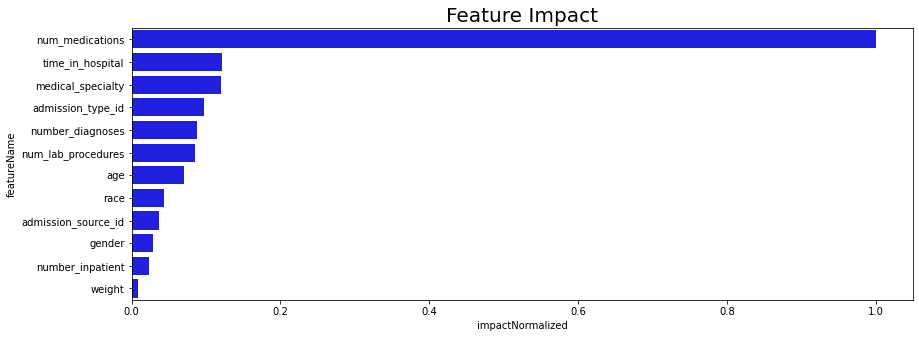

In [71]:
plot_feature_impact(propensity_model)

For a real research project, you would dive deeper into this model as well as other models on the leaderboard. For now, proceed with this top model.

## Calculate Inverse Propensity of Treatment Weights

Now that you have a propensity of treatment model, you will calculate the Inverse Propensity of Treatment Weights.

### Obtain propensity scores

As a first step, you must obtain the predictions from the Propensity of Treatment model.

To do this, submit the feature data from the propensity dataframe to the model via `request_predictions()`. 

Note that because we are submitting the same feature data as training, this will result in in-sample predictions, i.e., predictions from a model that has already seen this data. That is defensible in this case, where you are trying to characterize the propensity of treatment in this specific study population, rather than generalizing to future study populations. However, if you wanted out-of-sample predictions on the training data from DataRobot, you could use `model.request_training_predictions()` instead. 

In [75]:
scoring_df = propensity_df.drop(columns=["diabetesMed"])
scoring_df

,race,gender,age,weight,admission_type_id,admission_source_id,number_inpatient,medical_specialty,num_lab_procedures,number_diagnoses,num_medications,time_in_hospital
0,Caucasian,Female,[50-60),?,Elective,Physician Referral,0,Surgery-Neuro,35,9,21,1
1,Caucasian,Female,[20-30),[50-75),Urgent,Physician Referral,0,?,8,6,5,2
2,Caucasian,Male,[80-90),?,Not Available,NaN,1,Family/GeneralPractice,12,9,21,7
3,AfricanAmerican,Female,[50-60),?,Emergency,Transfer from another health care facility,0,?,33,3,5,4
4,AfricanAmerican,Female,[50-60),?,Emergency,Emergency Room,0,Psychiatry,31,7,13,5
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,Caucasian,Female,[60-70),?,Elective,Physician Referral,0,?,30,7,29,3
9996,AfricanAmerican,Male,[60-70),?,Urgent,Emergency Room,0,Emergency/Trauma,1,9,15,8
9997,AfricanAmerican,Female,[70-80),?,Emergency,Emergency Room,1,InternalMedicine,46,6,14,13
9998,Caucasian,Male,[80-90),?,Urgent,Emergency Room,3,InternalMedicine,62,9,7,2


In [76]:
predict_job = propensity_model.request_predictions(dataframe=scoring_df)
predict_job

PredictJob(Model('65a6eb2e6edd73b1994d580c'), status=queue)

In [77]:
propensity_predictions = predict_job.get_result_when_complete()
propensity_predictions

,row_id,prediction,positive_probability,prediction_threshold,class_No,class_Yes
0,0,Yes,0.812269,0.5,0.187731,0.812269
1,1,Yes,0.547232,0.5,0.452768,0.547232
2,2,Yes,0.889528,0.5,0.110472,0.889528
3,3,Yes,0.551166,0.5,0.448834,0.551166
4,4,Yes,0.769513,0.5,0.230487,0.769513
...,...,...,...,...,...,...
9995,9995,Yes,0.903911,0.5,0.096089,0.903911
9996,9996,Yes,0.832543,0.5,0.167457,0.832543
9997,9997,Yes,0.738654,0.5,0.261346,0.738654
9998,9998,Yes,0.709603,0.5,0.290397,0.709603


In [84]:
propensity_scores_df = (
    propensity_predictions[["row_id", "class_Yes"]]
    .set_index("row_id")
    .rename(columns={"class_Yes": "propensity_score"})
)
propensity_scores_df

,propensity_score
row_id,
0,0.812269
1,0.547232
2,0.889528
3,0.551166
4,0.769513
...,...
9995,0.903911
9996,0.832543
9997,0.738654


array([[<AxesSubplot:title={'center':'propensity_score'}>]], dtype=object)

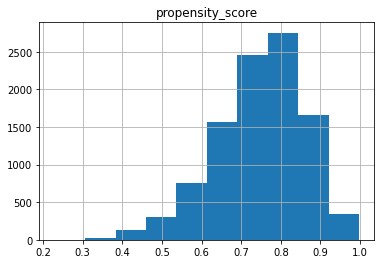

In [86]:
propensity_scores_df.hist()

### Compute Inverse Propensity of Treatment Weights
Now that you have your Propensity of Treatment scores, you can calculate the Inverse Propensity of Treatment weights and join them back to your original dataset.

In [171]:
def compute_iptw(df, stabilize=True):
    if stabilize:
        # Compute "stablized" weights to deal with extreme weight values
        numerator_treatment = (working_df.diabetesMed == "Yes").mean()
        numerator_control = (working_df.diabetesMed == "No").mean()
    else:
        # Use non-stablized weights
        numerator_treatment = 1
        numerator_control = 1
    return (df.diabetesMed == "Yes") * numerator_treatment / (df.propensity_score) + (
        df.diabetesMed == "No"
    ) * numerator_control / (1 - df.propensity_score)

In [172]:
iptw_df = (
    working_df.assign(
        row_id=lambda df: range(df.shape[0])
    )  # assign a 0 to (N-1) row ID, to match up with predictions
    .set_index("row_id")
    .join(propensity_scores_df, how="left")  # join propensity scores
    .assign(sampling_weight=compute_iptw)
)
iptw_df

,readmitted,race,gender,age,weight,admission_type_id,admission_source_id,number_inpatient,medical_specialty,num_lab_procedures,number_diagnoses,num_medications,time_in_hospital,diabetesMed,propensity_score,sampling_weight
row_id,,,,,,,,,,,,,,,,
0,False,Caucasian,Female,[50-60),?,Elective,Physician Referral,0,Surgery-Neuro,35,9,21,1,No,0.812269,1.343415
1,False,Caucasian,Female,[20-30),[50-75),Urgent,Physician Referral,0,?,8,6,5,2,No,0.547232,0.557018
2,True,Caucasian,Male,[80-90),?,Not Available,NaN,1,Family/GeneralPractice,12,9,21,7,Yes,0.889528,0.840671
3,False,AfricanAmerican,Female,[50-60),?,Emergency,Transfer from another health care facility,0,?,33,3,5,4,Yes,0.551166,1.356761
4,False,AfricanAmerican,Female,[50-60),?,Emergency,Emergency Room,0,Psychiatry,31,7,13,5,Yes,0.769513,0.971783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,False,Caucasian,Female,[60-70),?,Elective,Physician Referral,0,?,30,7,29,3,Yes,0.903911,0.827293
9996,False,AfricanAmerican,Male,[60-70),?,Urgent,Emergency Room,0,Emergency/Trauma,1,9,15,8,Yes,0.832543,0.898212
9997,True,AfricanAmerican,Female,[70-80),?,Emergency,Emergency Room,1,InternalMedicine,46,6,14,13,No,0.738654,0.965004


<AxesSubplot:xlabel='sampling_weight', ylabel='Density'>

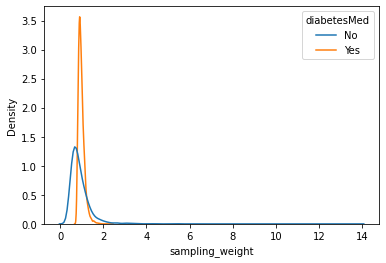

In [173]:
sns.kdeplot(data=iptw_df, x="sampling_weight", hue="diabetesMed", common_norm=False)

## Evaluate the causal relationship using Inverse Propensity of Treatment Weighting

Now that you have computed the Inverse Propensity of Treatment Weights, you can create adjusted treatment and control groups which should be more similar to each other on observed covariates, and thus more valid to compare to determine a causal relationship. 

### Examine adjusted treatment and control populations

To start, take a look at your covariates in the unadjusted vs. adjusted populations. You will see that the adjusted treatment and control groups are much more similar.

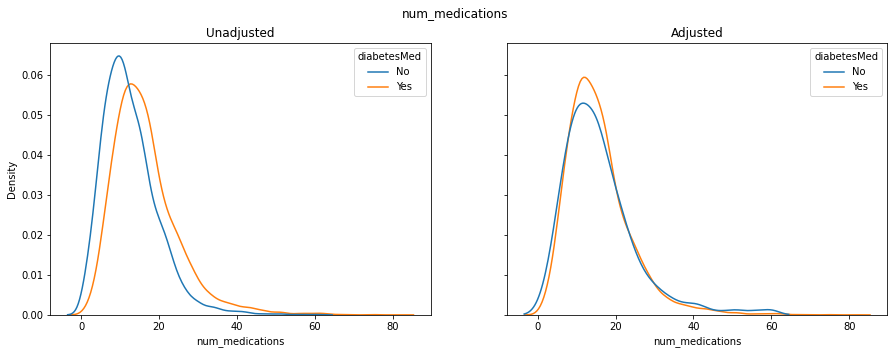

In [163]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("num_medications")
axes[0].set_title("Unadjusted")
axes[1].set_title("Adjusted")
sns.kdeplot(
    data=propensity_df, x="num_medications", hue="diabetesMed", common_norm=False, ax=axes[0]
)
sns.kdeplot(
    data=iptw_df,
    x="num_medications",
    hue="diabetesMed",
    common_norm=False,
    ax=axes[1],
    weights="sampling_weight",
)
None

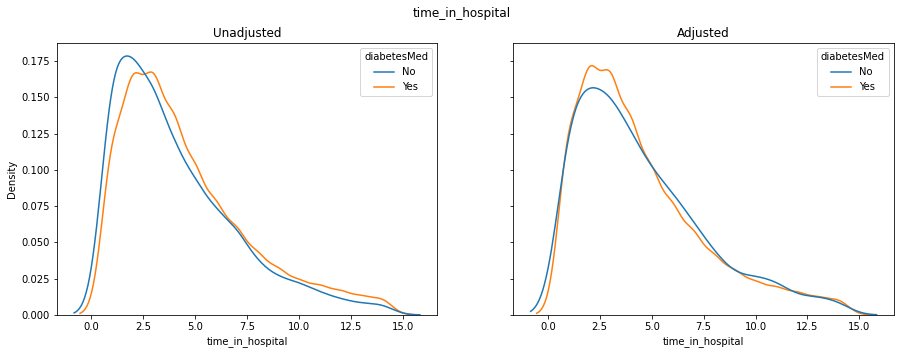

In [164]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("time_in_hospital")
axes[0].set_title("Unadjusted")
axes[1].set_title("Adjusted")
sns.kdeplot(
    data=propensity_df, x="time_in_hospital", hue="diabetesMed", common_norm=False, ax=axes[0]
)
sns.kdeplot(
    data=iptw_df,
    x="time_in_hospital",
    hue="diabetesMed",
    common_norm=False,
    ax=axes[1],
    weights="sampling_weight",
)
None

In [251]:
PERCENT_FORMAT_STRING_0_100 = (
    "{x:.1f}%"  # format string for formatting 0-100 floats as a percentage
)


def prepare_categorical_plot_df(categorical_var, weight=True):
    if not weight:
        plot_df = iptw_df.assign(sampling_weight=1)  # unweighted
    else:
        plot_df = iptw_df

    plot_df = (
        plot_df.groupby(["diabetesMed", categorical_var])
        .sampling_weight.sum()
        .pipe(
            lambda df: 100 * (df / df.groupby("diabetesMed").transform("sum"))
        )  # we are using 0-100 values for percentage (for compatibility with bar labels)
        .to_frame("percent")
        .reset_index()
    )

    return plot_df

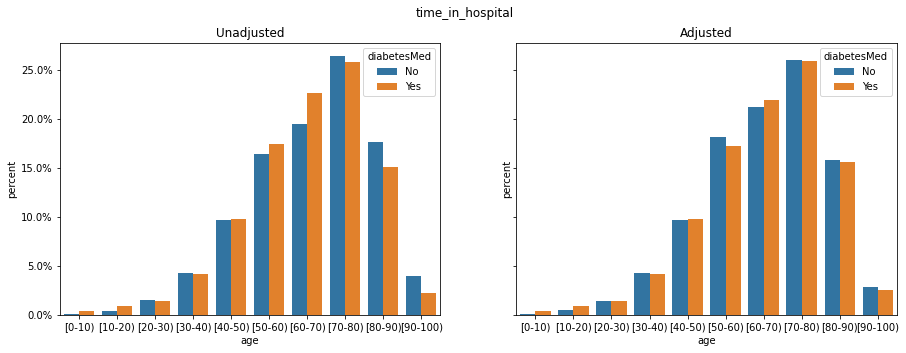

In [254]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("time_in_hospital")
axes[0].set_title("Unadjusted")
axes[1].set_title("Adjusted")
sns.barplot(
    data=prepare_categorical_plot_df("age", weight=False),
    x="age",
    y="percent",
    hue="diabetesMed",
    ax=axes[0],
)
sns.barplot(
    data=prepare_categorical_plot_df("age", weight=True),
    x="age",
    y="percent",
    hue="diabetesMed",
    ax=axes[1],
)
axes[0].yaxis.set_major_formatter(PERCENT_FORMAT_STRING_0_100)
None

For a complete analysis, you would continue to look at all of your covariates. You might also quantitatively assess the difference in treatment and control populations by using e.g. a standardized difference of means comparison to ensure that the treatment and control groups are comparable.

## Examine adjusted treatment effect
Now that you have more comparable treatment and control groups, it's time to look at your core outcome of interest: hospital readmission. How do the adjusted treatment and control groups look on this outcome?

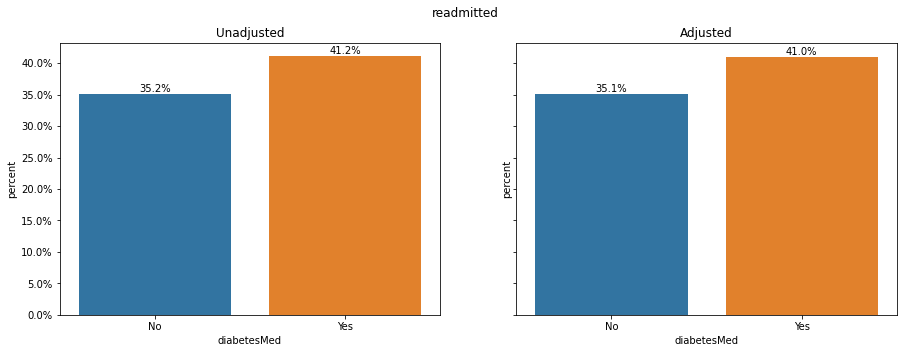

In [255]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
fig.suptitle("readmitted")
axes[0].set_title("Unadjusted")
axes[1].set_title("Adjusted")
sns.barplot(
    data=prepare_categorical_plot_df("readmitted", weight=False).pipe(
        lambda df: df[df.readmitted == True]
    ),
    x="diabetesMed",
    y="percent",
    ax=axes[0],
)
sns.barplot(
    data=prepare_categorical_plot_df("readmitted", weight=True).pipe(
        lambda df: df[df.readmitted == True]
    ),
    x="diabetesMed",
    y="percent",
    ax=axes[1],
)
axes[0].yaxis.set_major_formatter(PERCENT_FORMAT_STRING_0_100)
for ax in axes:
    for container in ax.containers:
        ax.bar_label(container, fmt="%.1f%%")
None

As you can see here, the treatment effect as measured from the adjusted treatment and control groups is nearly identical to the unadjusted treatment effect! Even after adjustment for your observed confounding variables, it still looks like patients on diabetes medication have higher readmission rates, which is an intriguing result.

What can you conclude from this? There are a few possibilities:
1. Diabetes medication really does cause an increased risk of readmission for diabetes hospital patients. What causal pathway could explain this?
1. There is an unobserved confounding variable that explains this association, which was not accounted for in the propensity of treatment model. For example, there is not a good measure of "severity of illness" in the observed variables, nor a measure of the reason for hospitalization. How would results differ if these variables were included?
1. Diabetes medication as you have measured it is not a sufficiently "consistent" measure, i.e. there are multiple types of medications that have different effects. What would happen if you analyzed the effect of specific medications?

The path doesn't end here! Further evaluation of assumptions, the inclusion of additional data, and engagement with other research lie ahead in refining this use case.

For whatever use case you'd like to tackle with Inverse Propensity of Treatment Weighting, the DataRobot platform is a powerful tool for obtaining the most effective propensity scores and disentangling confounding factors from your treatment effect.